# 2020-12-30 • Test connection of _all_ incoming neurons

In the previous notebooks ({doc}`/notebooks/2020-11-27__permutation_test` and {doc}`/notebooks/2020-11-30__speedup__spike_indices.ipynb`) we have tested the connection to the simulated neuron of just one of the 30 generated spike trains .

Here we test the connection of all spike trains.

## Setup

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading:
 - numpy … (0.10 s)
 - matplotlib.pyplot … (0.22 s)
 - numba … (0.30 s)

Importing from submodules (compiling numba functions) … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Wed 30 Dec** 2020, at 18:16 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1b3a4f6000c5f7d90f8c184d1b37fcbaa76e9fa5
) (Wed 30 Dec 2020, 18:16).

No uncommitted changes

Simulation duration & timestep.

In [3]:
tg = v.TimeGrid(
    duration = 10 * minute,
    timestep = 0.1 * ms
);

A short time slice to visualise a zoomed in part of the generated signals.

In [4]:
zoom_range = 1 * minute + np.array([0, 1]) * second

zoom_range_indices = np.round(zoom_range / tg.timestep).astype(int)
i_zoom = slice(*zoom_range_indices)
t_zoom = tg.time[i_zoom];

## 1. Biology model

### Spike trains

In [5]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

In [6]:
f_spike = 20 * Hz;

In [7]:
v.fix_rng_seed()
spike_trains_connected = [v.generate_Poisson_spikes(f_spike, tg.duration) for _ in range(N_connected)]
spike_trains_unconnected = [v.generate_Poisson_spikes(f_spike, tg.duration) for _ in range(N_unconnected)]
all_spike_trains = spike_trains_connected + spike_trains_unconnected
all_incoming_spikes = np.concatenate(spike_trains_connected);

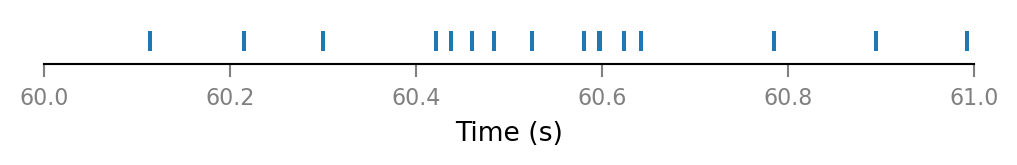

In [8]:
v.spike_trains.plot(all_spike_trains[0], zoom_range);

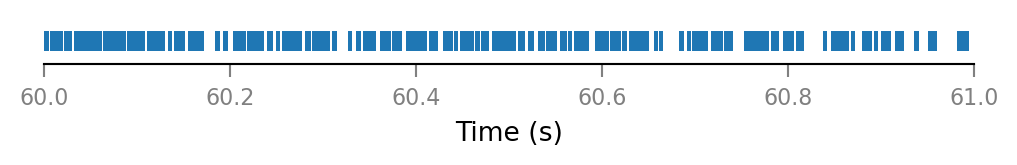

In [9]:
v.spike_trains.plot(all_incoming_spikes, zoom_range);

### Synaptic conductance

In [10]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms;

In [11]:
g_syn = v.calc_synaptic_conductance(tg, all_incoming_spikes, Δg_syn, τ_syn);

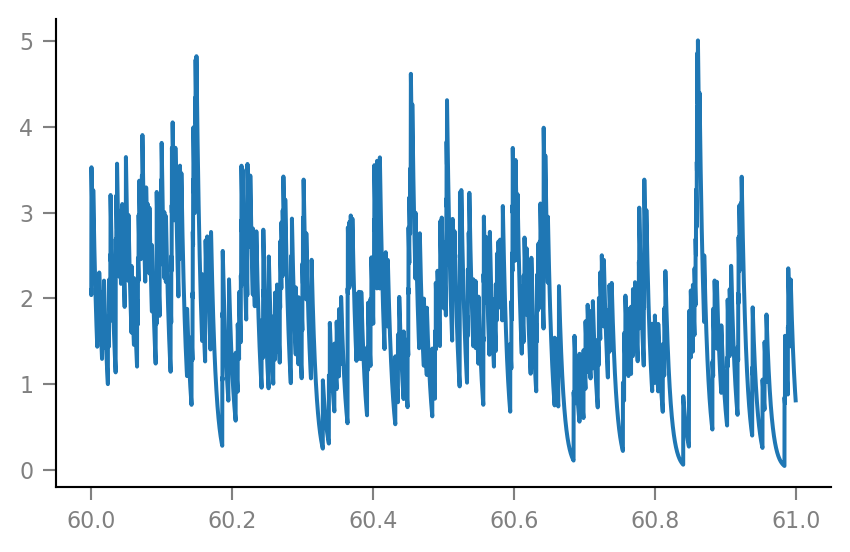

In [12]:
plt.plot(t_zoom / second, g_syn[i_zoom] / nS);

### Membrane voltage

In [13]:
params = v.params.cortical_RS
v.pprint(params)

IzhikevichParams
----------------
     C = 1E-10
     k = 7E-07
   v_r = -0.06
   v_t = -0.04
v_peak = 0.035
     a = 30
     b = -2E-09
     c = -0.05
     d = 1E-10
 v_syn = 0


In [14]:
sim = v.simulate_izh_neuron(tg, params, g_syn);

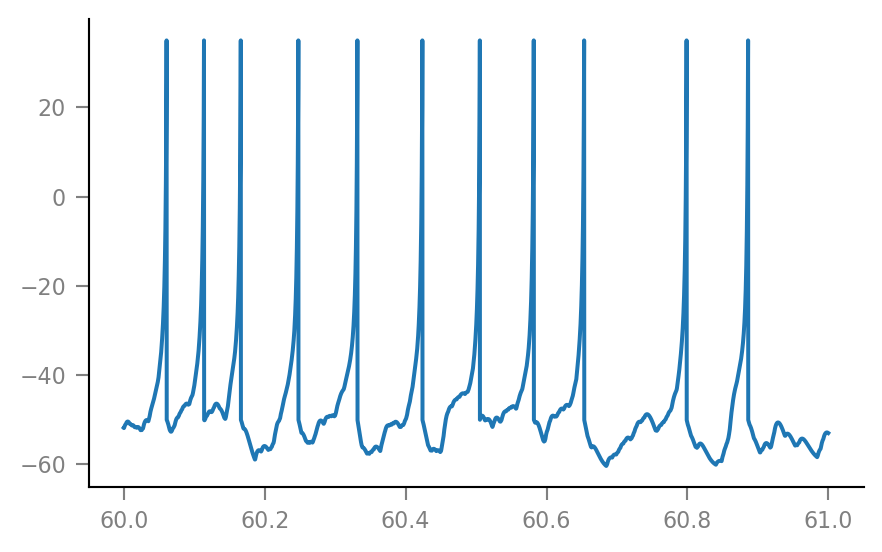

In [15]:
plt.plot(t_zoom / second, sim.V_m[i_zoom] / mV);

## 2. Imaging model

In [16]:
VI_signal = v.add_VI_noise(sim.V_m, params);

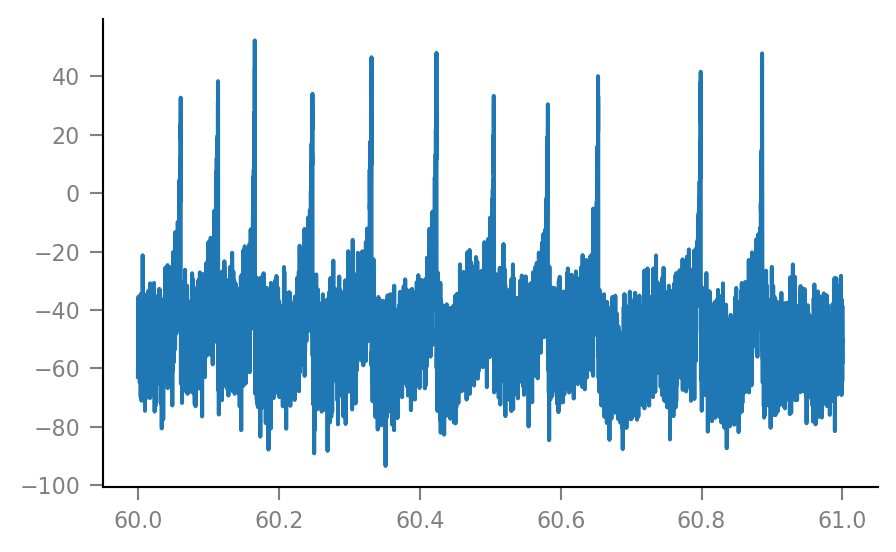

In [17]:
plt.plot(t_zoom / second, VI_signal[i_zoom] / mV);

## 3. Connection detection

Permutation test for each generated spike train (using height of average spike-triggered window as test statistic):

In [18]:
from tqdm.notebook import tqdm as time_loop

test_data, test_summaries = [], []

for spike_train in time_loop(all_spike_trains):
    test_data_, test_summary = (
        v.test_connection(
            spike_train,
            VI_signal,
            window_duration=100 * ms,
            num_shuffles=100
        )
    )
    test_data.append(test_data_)
    test_summaries.append(test_summary)

  0%|          | 0/30 [00:00<?, ?it/s]

### Example results

In [19]:
def show_test_results(spike_train_nr: int):
    v.connection_test.plot(test_data[spike_train_nr])
    v.pprint(test_summaries[spike_train_nr])

..for two connected neurons:

ConnectionTestSummary
---------------------
            p_value = 0.01
       p_value_type = '<'
relative_STA_height = 3.565


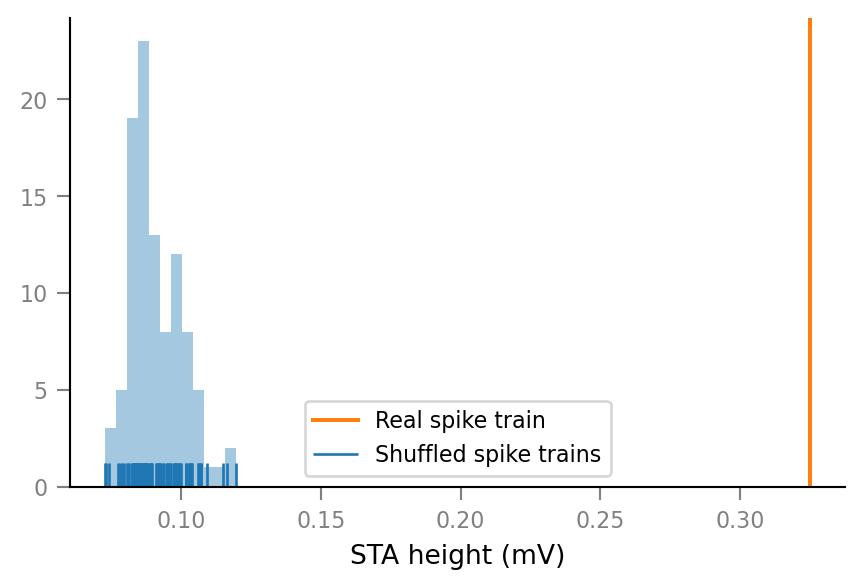

In [20]:
show_test_results(spike_train_nr=0)

ConnectionTestSummary
---------------------
            p_value = 0.01
       p_value_type = '<'
relative_STA_height = 3.663


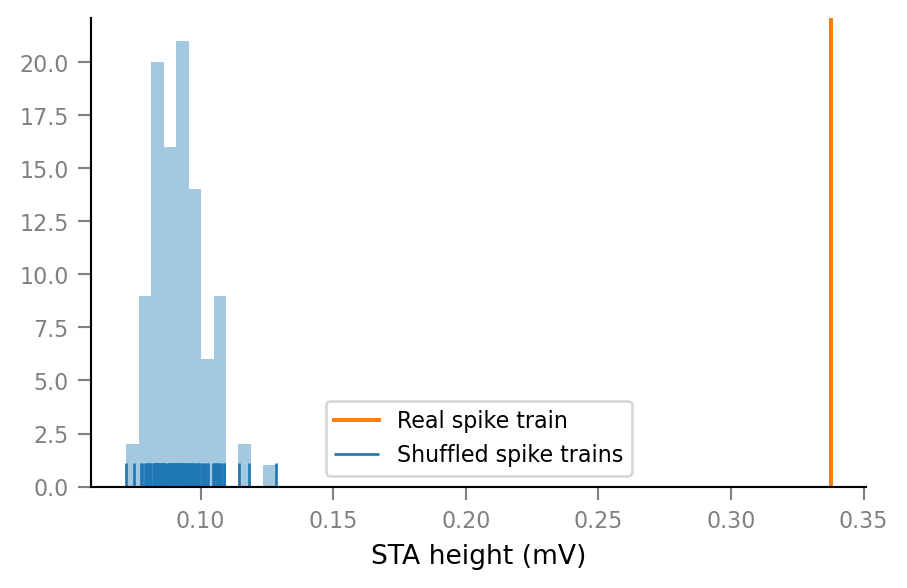

In [21]:
show_test_results(spike_train_nr=14)

and an unconnected neuron:

ConnectionTestSummary
---------------------
            p_value = 0.85
       p_value_type = '='
relative_STA_height = 0.8996


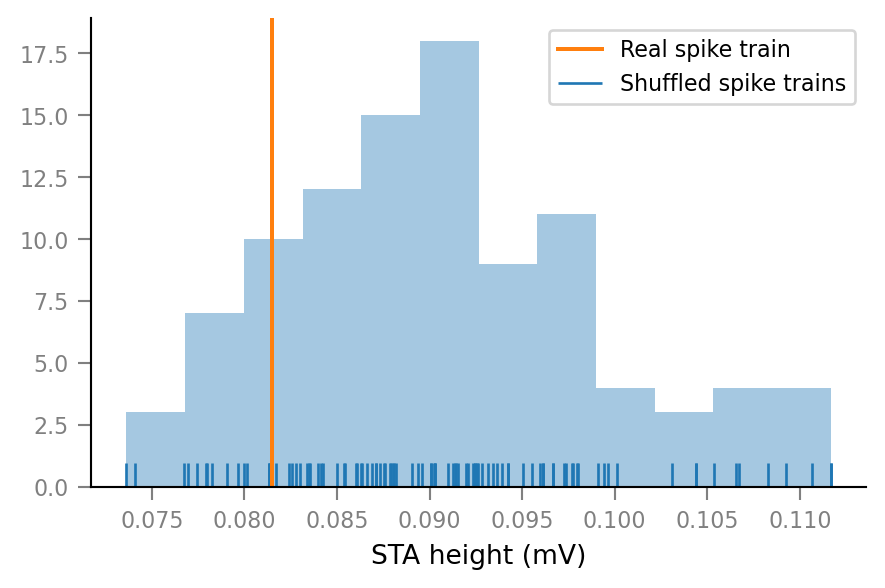

In [22]:
show_test_results(spike_train_nr=15)

Note that "STA height" is defined as the difference between the maximum and the minimum of the average spike-triggered VI signal window.

### Distribution of p-values

In [23]:
p_values = [test_summary.p_value for test_summary in test_summaries];

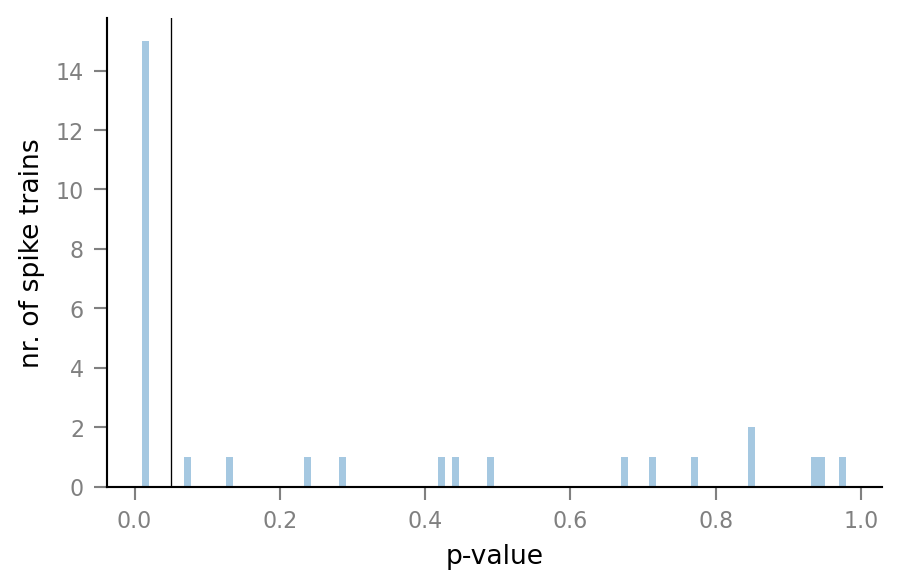

In [24]:
import seaborn as sns

ax = sns.distplot(p_values, kde=False, bins=100)
ax.set(xlabel="p-value", ylabel="nr. of spike trains")
ax.axvline(0.05, color='black', lw=0.5);

One unconnected spike train almost reaches the (arbitrary) p-value threshold of 0.05 for classification as being connected.

Which spike train is it?

In [25]:
min([(spike_train_nr, p_value)
     for spike_train_nr, p_value in enumerate(p_values)
     if p_value > 0.01],
    key=lambda tup: tup[1])

(20, 0.07)

ConnectionTestSummary
---------------------
            p_value = 0.07
       p_value_type = '='
relative_STA_height = 1.156


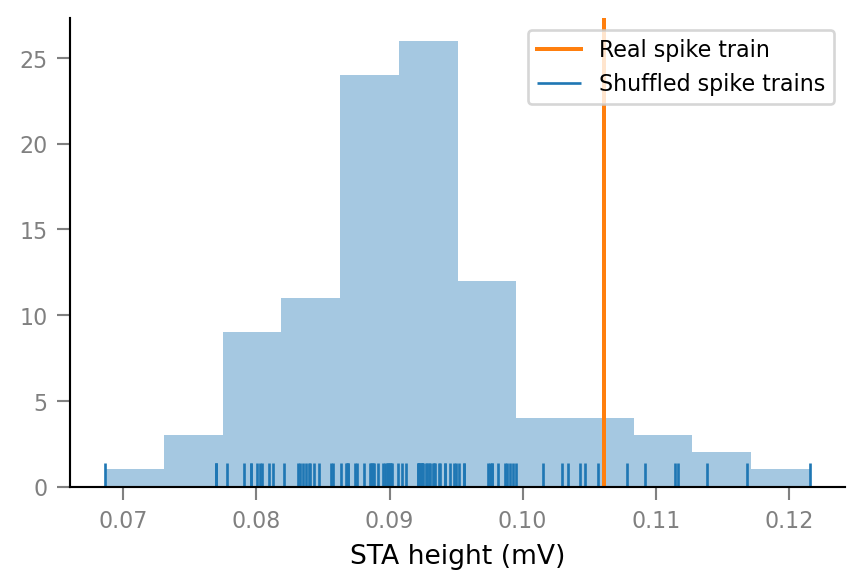

In [26]:
show_test_results(spike_train_nr=20)

### Distribution of relative STA heights

`relative_STA_height` is defined as the height of the original spike train's STA window divided by the mean height of the shuffled spike train's STA windows. This is their distribution over the different connected & unconnected spike trains:

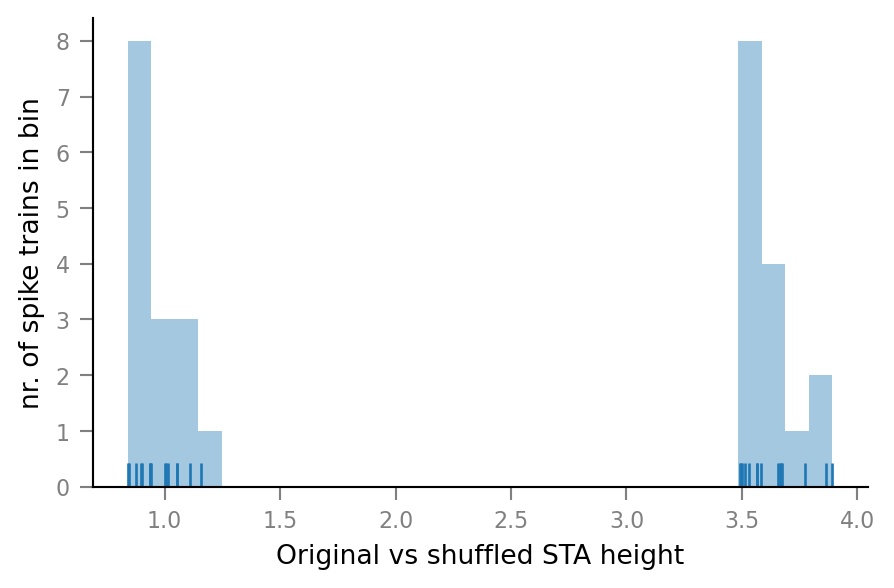

In [27]:
ax = sns.distplot([test_summary.relative_STA_height for test_summary in test_summaries],
                  kde=False, bins=30, rug=True)
ax.set(xlabel="Original vs shuffled STA height", ylabel="nr. of spike trains in bin");

The connected & unconnected spike trains can be clearly separated.

## Reproducibility info

In [28]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Wed 30 Dec** 2020, at 18:17 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1b3a4f6000c5f7d90f8c184d1b37fcbaa76e9fa5
) (Wed 30 Dec 2020, 18:16).

Uncommited changes to:
```
 M notebooks/2020_12_30__test_all_connections.ipynb
```

Platform:

Windows-10
CPython 3.8.3 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.2
numba                0.51.2
seaborn              0.10.1
scipy                1.5.2
scikit-learn         0.23.2
preload              2.1
py-cpuinfo           7.0.0
nptyping             1.3.0
tqdm                 4.55.0
